# Zipf’s and Gibart’s Laws

In [1]:
import numpy as np
import pandas as pd
import sklearn.neighbors
from sklearn.neighbors import KernelDensity
import scipy
from matplotlib import pyplot as plt
from scipy.stats import pareto
from scipy.optimize import fsolve
from tabulate import tabulate

In [2]:
from numpy.random import seed
from numpy.random import randn
from numpy.random import lognormal

In [3]:
data = pd.read_csv("/Users/brunokomel/Downloads/US_supermarkets.csv")
df = pd.DataFrame(data, columns=['firm','number_of_stores'])

In [4]:
display(df)

,firm,number_of_stores
0,114 Grocery & Deli Incorporated,1
1,1st Oriental Supermarket,2
2,A & A Fine Foods,1
3,A & G Fine Foods Incorporated,1
4,A & P Food Stores,109
...,...,...
632,White Market,5
633,Whites Fresh Foods,13
634,Whole Foods Market,68
635,Winco,14


In [5]:
print(len(df.firm.unique()))
print(len(df))
#so there are no stores with repeated values (although from looking at the data some of these are really close)

637
637


(array([ 38., 104.,   0., 123.,  53.,  81.,  59.,  44.,  25.,  24.,  19.,
         15.,  10.,  17.,   6.,   6.,   1.,   3.,   3.,   4.,   1.,   1.]),
 array([0.        , 0.35728114, 0.71456228, 1.07184342, 1.42912456,
        1.78640569, 2.14368683, 2.50096797, 2.85824911, 3.21553025,
        3.57281139, 3.93009253, 4.28737367, 4.64465481, 5.00193595,
        5.35921708, 5.71649822, 6.07377936, 6.4310605 , 6.78834164,
        7.14562278, 7.50290392, 7.86018506]),
 <BarContainer object of 22 artists>)

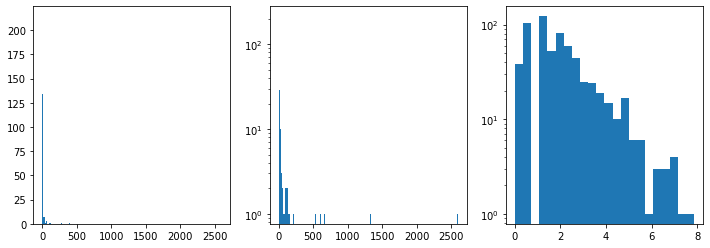

In [6]:
fig, (ax0,ax1,ax2) = plt.subplots(ncols =3, figsize =(12,4))

ax0.hist(df.number_of_stores, bins = 'auto')
ax1.hist(df.number_of_stores, bins = 'auto', log = True)
ax2.hist(np.log(df.number_of_stores), bins = 'auto' , log = True)

## 1. State Zipf’s Law. Why does Zipf’s Law suggest that certain variables have a Pareto distribution?


Zipfs law, which originally concerns frequency of words in liguistics, states that given some population, the frequency of any event is inversely proportional to its rank in the frequency table. More clearly, the most frequent event occurs about twice as often as the second most frequent event, three times as often as the third most frequent event, etc. 

Zipf's law suggests that certain variables follow a Pareto distribution because it is analogous to the continous Pareto distribution in the same way that the discrete uniform distribution is analogous to the continuous uniform distribution (from Wikipedia). 

## 2. State Gibart’s Law. Why does Gibart’s Law suggest that certain variables have a Log-Normal distribution?


Gilbart's law states that the proportional rate of growth of a firm is independent of its absolute size, thus the law of proportional growth gives rise to a firm size distribution that is log-normal (from Wikipedia).

## 3. Let Si be the number of stores that a supermarket chain i has. Estimate the density of S using a kernel density estimator. Indicate your choice of kernel function and bandwidth and justify these selections.


In [7]:
#display(df.number_of_stores[:])
#type(df.number_of_stores)
(df['number_of_stores'])
df.head()

,firm,number_of_stores
0,114 Grocery & Deli Incorporated,1
1,1st Oriental Supermarket,2
2,A & A Fine Foods,1
3,A & G Fine Foods Incorporated,1
4,A & P Food Stores,109


In [8]:
df.number_of_stores

0        1
1        2
2        1
3        1
4      109
      ... 
632      5
633     13
634     68
635     14
636    608
Name: number_of_stores, Length: 637, dtype: int64

In [9]:
num_stores = df[['number_of_stores']].to_numpy()
np.shape(num_stores)

(637, 1)

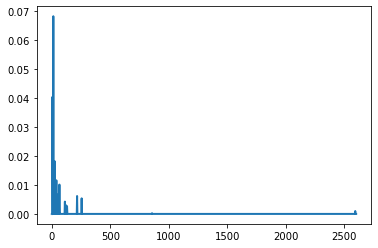

In [10]:
#Just picking arbitrary bandwidth and kernel selection

kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.1).fit(num_stores) # This generates the kernel density
X_plot = np.linspace(0, 2600, 1000)[:, np.newaxis] #Here we're creating a grid 
log_dens = kde.score_samples(X_plot) # Now we use the density that we created to generate the kernels for each X on the grid
plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=2,
        linestyle="-")

In [11]:
#Next we need to find the optimal bandwidth. We choose to do that by Silverman's rule of thumb.
q1, q3 = np.percentile(df.number_of_stores, [25,75])
iqr = q3-q1

silvermans_hn = 0.9*np.minimum(np.var(num_stores),iqr/1.35)*len(num_stores)**(-1/5)
bw = silvermans_hn

(-200.0, 2692.0)

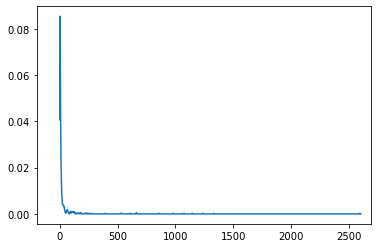

In [12]:
# Noting that the choice of kernel estimator is not as important as the choice of bandwidth
# we go with the default setting and choose the Gaussian density
kde = KernelDensity(kernel = 'gaussian', bandwidth = bw).fit(num_stores)
X_plot = np.linspace(0, 2600, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)


plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)

In [13]:
x̄ = np.mean(num_stores)
xₘ = np.min(num_stores)
n = len(num_stores)

## 4. Using a GMM estimate the Pareto distribution that fits the data. Report your results.

In [14]:
#From GMM we obtain the following estimates:
α = (n*x̄ - xₘ)/(n*(x̄-xₘ))
x̂ₘ = ((n*α - 1)*xₘ)/(n*α)
x = np.linspace(0, 2600, len(num_stores))

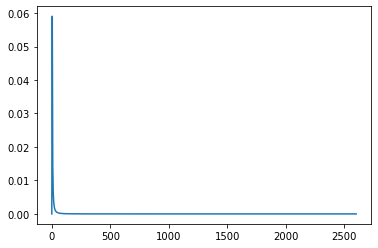

In [15]:
output = np.array([scipy.stats.pareto.pdf(x, scale = x̂ₘ, b = α)])
plt.plot(x, output.T)
plt.show()

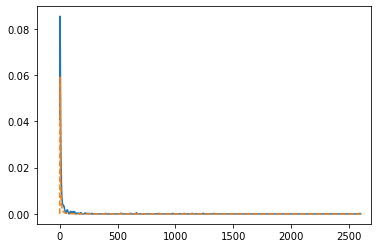

In [16]:
#Overlaying the two plots
plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)

output = np.array([scipy.stats.pareto.pdf(x, scale = x̂ₘ, b = α)])
plt.plot(x, output.T, linestyle="--")
plt.show()

## 5. Using GMM estimate the log-Normal distribution that fits the data. Report your results.

In [17]:
#From GMM we obtain the following estimates:
μₓ = np.mean(num_stores)
σₓˢ = np.mean(num_stores**2) - μₓ**2

$\mu_x = \exp(\mu_y + \frac{\sigma_y^2}{2})$

$\sigma_x^2 = [\exp(\sigma_y^2 - 1)]\exp(2\mu_y + \sigma_y^2)$

In [19]:
def bsolve(z):
    x = z[0]
    y = z[1]
    
    F = np.empty((2))
    F[0] = np.exp(x + y/2) - μₓ
    F[1] = (np.exp(y)-1)*np.exp(2*x + y) -σₓˢ
    
    return F

zGuess = np.array([2,2])
z = fsolve(bsolve,zGuess)
μ = z[0]
σˢ = z[1]

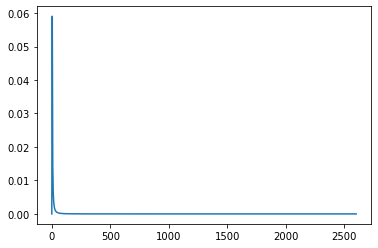

In [20]:
output_ln = np.array([scipy.stats.lognorm.pdf(x, scale = np.exp(μ), s = np.sqrt(σˢ))])
plt.plot(x, output.T)
plt.show()

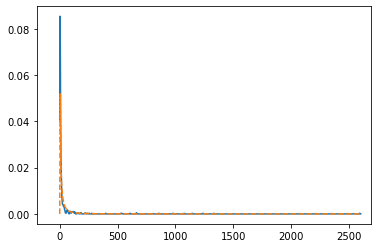

In [21]:
#Overlaying the two plots
plt.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        lw=1.5,
        linestyle="-")
plt.xlim(-200,np.max(num_stores)+100)

#plt.plot(x, output.T, linestyle="-.")
plt.plot(x, output_ln.T, linestyle="--")
plt.show()

## 6. Using a Kolmogorov-Smirnov test determine whether the log-Normal or the Pareto distribution represent the data. Which one is doing better according the K-S statistics?


In [22]:
data2 = scipy.stats.pareto.rvs(size = len(num_stores), scale = x̂ₘ, b = α)
ks_pareto = scipy.stats.ks_2samp(df.number_of_stores, data2)

In [23]:
data3 = scipy.stats.lognorm.rvs(size = len(num_stores), scale = np.exp(μ), s = np.sqrt(σˢ))
ks_ln = scipy.stats.ks_2samp(df.number_of_stores, data3)

In [24]:
table = [
    ['Distribution', 'K-S Stat.', 'P-value'], 
         ['Pareto', round(ks_pareto[0],4), round(ks_pareto[1],4)],
         ['Log_normal', round(ks_ln[0],4), round(ks_ln[1],4)]
        ]
print(tabulate(table))

------------  ---------  -------
Distribution  K-S Stat.  P-value
Pareto        0.4301     0.0
Log_normal    0.1727     0.0
------------  ---------  -------


In [25]:
 ks_ln[1] - ks_pareto[1] >0 

True

We conclude that the Pareto distribution fits the data better, since the K-S statistic is lower, and the P-value is higher (though marginally so) for the log-normal distribution.